<a href="https://colab.research.google.com/github/Jinyong-20/Machine_Learning_Programming/blob/master/lesson3_camvid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with CamVid

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


\# 드라이브에 마운트

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

\# 수정시 자동 리로드

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

\# 함수들 임포트

In [21]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

\# URL에 있는 데이터 받아오기

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

\# 경로를 저장

## Subset classes

In [8]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

IndexError: ignored

Q? 실행시 오류가 발생하는데 원인을 잘 모르겠습니다

## Data

In [23]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00990.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06450.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_04530.png')]

\# 이미지 이름 받아오기

In [24]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02040_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01290_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_010020_P.png')]

\# 라벨 이름 받아오기

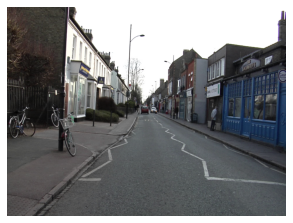

In [25]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

\# 첫번째 이미지를 출력

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

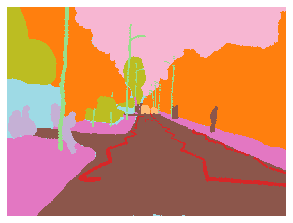

In [30]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

\# 이미지에 마스크효과 주기

In [16]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

\# 모든 마스크 이미지에 사이즈 조절

In [31]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

\# 코드 텍스트 불러와서 출력

## Datasets

In [32]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


\# 사이즈와 batchsize 설정

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

\# 데이터 번치 생성

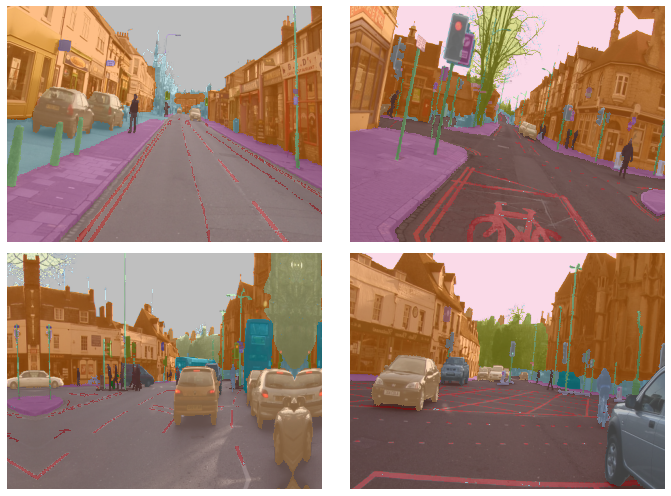

In [37]:
data.show_batch(2, figsize=(10,7))

\# 2x2, 가로10 세로 7로 출력

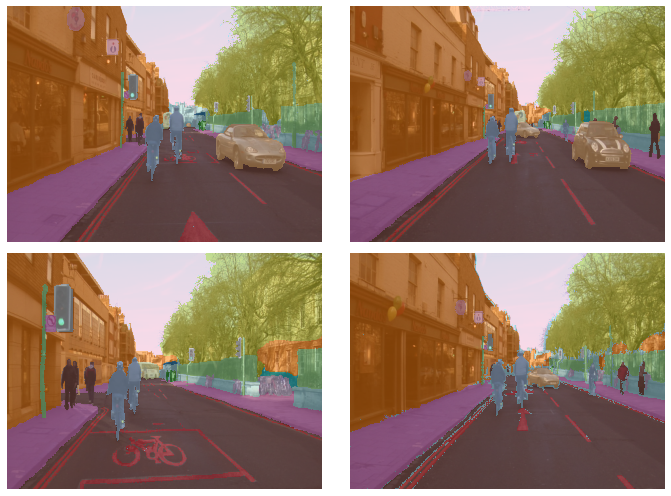

In [38]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

\# 데이터 셋 유형을 valid로 출력

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

\# id에 대응하는 딕셔너리 생성 및 acc_camvid 정의

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [42]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


\# 러너 불러오기, 츌력에 acc_camvid 표시

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


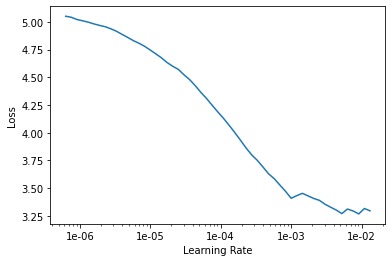

In [44]:
lr_find(learn)
learn.recorder.plot()

\# 최적값 탐색

In [0]:
lr=3e-3

In [46]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.989790,0.692486,0.825932,01:37
1,0.763325,0.580602,0.851130,01:36
2,0.666121,0.533942,0.850866,01:37
3,0.607525,0.426693,0.879342,01:37
4,0.620504,0.488800,0.869782,01:36
5,0.573481,0.395834,0.884909,01:36
6,0.565788,0.473851,0.872001,01:36
7,0.552316,0.395659,0.890513,01:35
8,0.498118,0.394341,0.886093,01:35
9,0.410274,0.327284,0.901661,01:35


\# 학습율 수정 및 10회 학습

In [0]:
learn.save('stage-1')

\#학습 결과 저장

In [0]:
learn.load('stage-1');

\# 학습 불러오기

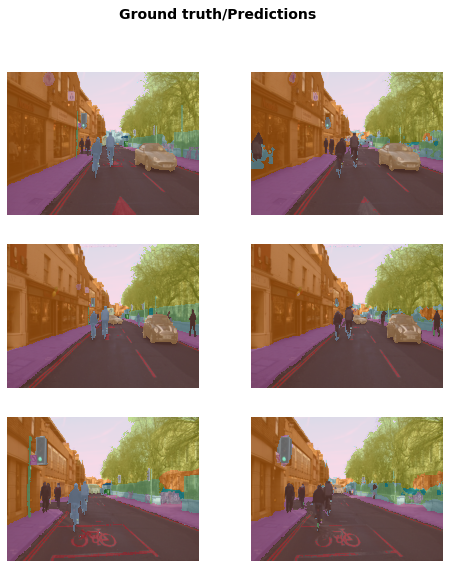

In [49]:
learn.show_results(rows=3, figsize=(8,9))

\# 학습 결과를 출력

In [0]:
learn.unfreeze()

\# 러너 재가동

In [0]:
lrs = slice(lr/400,lr/4)

\# 학습율 수정

In [52]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.367428,0.317420,0.901760,01:40
1,0.372549,0.308897,0.905322,01:40
2,0.358592,0.298720,0.908308,01:41
3,0.344640,0.301541,0.907089,01:41
4,0.338650,0.307932,0.909003,01:41
5,0.332087,0.282257,0.917555,01:41
6,0.330017,0.300723,0.915790,01:41
7,0.322046,0.279721,0.919873,01:41
8,0.319485,0.316743,0.909611,01:41
9,0.302202,0.308599,0.910710,01:42


\# 12회 학습

In [0]:
learn.save('stage-2');

\# 학습 결과 저장

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [54]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7074MB of GPU RAM free


\# 러너 삭제, 사이즈 변경

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

\# 데이터 번치 생성

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

\# 새로운 러너 불러오기

In [0]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


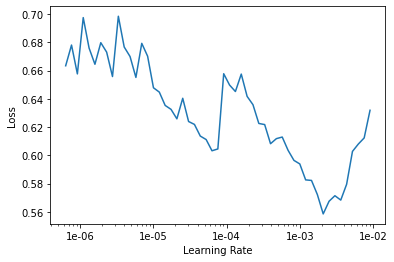

In [58]:
lr_find(learn)
learn.recorder.plot()

\# 최적값 탐색

In [0]:
lr=1e-3

In [60]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.416056,0.335007,0.907711,06:40
1,0.431229,0.368206,0.898843,06:41
2,0.333118,0.304440,0.918196,06:40


\# 학습율 변경해서 3회 수행

In [0]:
learn.save('stage-1-big')

\# 학습 저장

In [0]:
learn.load('stage-1-big');

\# 학습 불러오기

In [0]:
learn.unfreeze()

\# 러너 재가동

In [0]:
lrs = slice(1e-6,lr/10)

In [66]:
learn.fit_one_cycle(1, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.302472,0.299302,0.923263,07:02


\# 학습율 수정하고 1회 학습

In [0]:
learn.save('stage-2-big')

\# 학습 저장

In [0]:
learn.load('stage-2-big');

\# 학습 불러오기

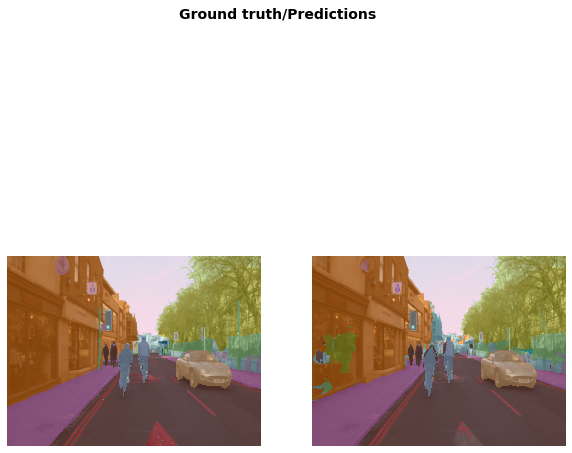

In [70]:
learn.show_results(rows=3, figsize=(10,10))

\# 학습 결과 출력

## fin